# `How Transferable are AI Features?` 


## Tidying The Path

In [87]:
import os
import shutil

val_dir = "/kaggle/input/imagetiny/tiny-imagenet-200/val"
img_dir = os.path.join(val_dir, "images")
ann_file = os.path.join(val_dir, "val_annotations.txt")
target_dir = "/kaggle/working/val_fixed"

# Create output directory
os.makedirs(target_dir, exist_ok=True)

# Read annotations
annotations = {}
with open(ann_file, "r") as f:
    for line in f:
        parts = line.strip().split('\t')
        filename = parts[0]
        class_name = parts[1]
        annotations[filename] = class_name

# Move images to class-specific folders
for img_filename in os.listdir(img_dir):
    if img_filename not in annotations:
        continue
    class_name = annotations[img_filename]
    class_dir = os.path.join(target_dir, class_name)
    os.makedirs(class_dir, exist_ok=True)

    src = os.path.join(img_dir, img_filename)
    dst = os.path.join(class_dir, img_filename)
    shutil.copy(src, dst)

print("✅ Validation set reorganized for ImageFolder.")


✅ Validation set reorganized for ImageFolder.


## Imports

In [1]:
import tensorflow as tf 
from tensorflow.keras.applications import ResNet50 
import numpy as np
import tensorflow_datasets as tfds
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import os
import random
from glob import glob
from keras.models import *
from keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array,array_to_img
from IPython.display import display
from PIL import Image

### First Experiment (With Mistakes)

In [ ]:

"""
# --- Reproducibility ---
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True

# --- Config ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 64
epochs_pretrain = 10
epochs_finetune = 10
lr = 1e-4

# --- Model Setup ---
def get_pretrained_alexnet(num_classes=100):
    model = models.alexnet(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    model.classifier = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(256 * 6 * 6, 4096),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(4096, num_classes)
    )
    return model.to(device)

# --- Data Loading ---
def load_cifar100(val_ratio=0.2):
    transform = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    train_data = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
    test_data = datasets.CIFAR100(root='./data', train=False, transform=transform)
    
    # Stratified split
    targets = [label for _, label in train_data]
    train_idx, val_idx = train_test_split(
        np.arange(len(train_data)),
        test_size=val_ratio,
        random_state=SEED,
        stratify=targets
    )
    return Subset(train_data, train_idx), Subset(train_data, val_idx), test_data

# --- Training Utilities ---
def train_epoch(model, loader, optimizer, criterion, epoch_num):
    model.train()
    epoch_loss = 0.0
    correct = 0
    total = 0
    all_probs = []
    all_labels = []
    
    # Nested tqdm for batches
    batch_iter = tqdm(loader, desc=f"Epoch {epoch_num} Training", leave=False)
    for inputs, labels in batch_iter:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Track metrics
        epoch_loss += loss.item()
        probs = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(probs, 1)
        
        all_probs.append(probs.detach().cpu())
        all_labels.append(labels.cpu())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Update progress bar
        batch_iter.set_postfix({
            'loss': epoch_loss / (batch_iter.n + 1),
            'acc': correct / total
        })
    
    return {
        'loss': epoch_loss / len(loader),
        'accuracy': correct / total,
        'probs': torch.cat(all_probs),
        'labels': torch.cat(all_labels)
    }

def eval_epoch(model, loader, criterion, desc="Validating"):
    model.eval()
    epoch_loss = 0.0
    correct = 0
    total = 0
    all_probs = []
    all_labels = []
    
    with torch.no_grad():
        # tqdm for validation batches
        batch_iter = tqdm(loader, desc=desc, leave=False)
        for inputs, labels in batch_iter:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(probs, 1)
            
            all_probs.append(probs.cpu())
            all_labels.append(labels.cpu())
            epoch_loss += loss.item()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            batch_iter.set_postfix({
                'loss': epoch_loss / (batch_iter.n + 1),
                'acc': correct / total
            })
    
    return {
        'loss': epoch_loss / len(loader),
        'accuracy': correct / total,
        'probs': torch.cat(all_probs),
        'labels': torch.cat(all_labels)
    }

# --- Full Training Loop ---
def train_model(model, train_loader, val_loader, epochs=10):
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    history = {
        'train': [],
        'val': []
    }
    
    # Main epoch loop with tqdm
    epoch_iter = tqdm(range(epochs), desc="Total Progress")
    for epoch in epoch_iter:
        # Train phase
        train_metrics = train_epoch(model, train_loader, optimizer, criterion, epoch+1)
        history['train'].append(train_metrics)
        
        # Validation phase
        val_metrics = eval_epoch(model, val_loader, criterion)
        history['val'].append(val_metrics)
        
        # Update epoch progress
        epoch_iter.set_postfix({
            'train_loss': train_metrics['loss'],
            'val_acc': val_metrics['accuracy']
        })
        
        print(f"\nEpoch {epoch+1}/{epochs}")
        print(f"Train Loss: {train_metrics['loss']:.4f} | Val Loss: {val_metrics['loss']:.4f}")
        print(f"Train Acc: {train_metrics['accuracy']:.4f} | Val Acc: {val_metrics['accuracy']:.4f}")
    
    return history

# --- Experiment Setup ---
def run_full_experiment():
    # Load data
    train_data, val_data, test_data = load_cifar100()
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size)
    test_loader = DataLoader(test_data, batch_size=batch_size)
    
    # Initialize model
    model = get_pretrained_alexnet()
    
    # Train model with progress bars
    print("Starting training...")
    history = train_model(model, train_loader, val_loader, epochs=epochs_finetune)
    
    # Final test evaluation
    print("\nRunning final test evaluation...")
    test_metrics = eval_epoch(model, test_loader, nn.CrossEntropyLoss(), desc="Testing")
    
    return {
        'model': model,
        'history': history,
        'test_metrics': test_metrics
    }

# --- Analysis Tools ---
def plot_learning_curves(history):
    train_loss = [e['loss'] for e in history['train']]
    val_loss = [e['loss'] for e in history['val']]
    train_acc = [e['accuracy'] for e in history['train']]
    val_acc = [e['accuracy'] for e in history['val']]
    
    loss_curve = hv.Curve(train_loss, label='Train') * hv.Curve(val_loss, label='Val') 
    acc_curve = hv.Curve(train_acc, label='Train') * hv.Curve(val_acc, label='Val')
    
    return (loss_curve.opts(title="Loss", width=600) + acc_curve.opts(title="Accuracy", width=600)).cols(1)

# --- Main Execution ---
results = run_full_experiment()
print(f"\nFinal Test Accuracy: {results['test_metrics']['accuracy']:.4f}")

# Plot learning curves
plot_learning_curves(results['history'])
"""

In [ ]:
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
import numpy as np
import random
from tqdm.notebook import tqdm
import holoviews as hv
import panel as pn
from sklearn.model_selection import train_test_split
hv.extension('bokeh')

# --- Reproducibility ---
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True

# --- Config ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 64
epochs_pretrain = 5  # Reduced for demonstration
epochs_finetune = 5
lr = 1e-4

# --- Model Setup ---
def get_pretrained_alexnet(num_classes=100):
    model = models.alexnet(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    model.classifier = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(256 * 6 * 6, 4096),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(4096, num_classes)
    )
    return model.to(device)

# --- Data Loading ---
def load_cifar100():
    transform = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    train_data = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
    test_data = datasets.CIFAR100(root='./data', train=False, transform=transform)
    return train_data, test_data

def split_cifar100_half_classes(dataset):
    """Split into first 50 classes (deterministic)"""
    targets = np.array(dataset.targets)
    chosen_classes = np.arange(50)
    idx = [i for i, t in enumerate(targets) if t in chosen_classes]
    return Subset(dataset, idx), chosen_classes

# --- Training Utilities ---
def train_epoch(model, loader, optimizer, criterion, desc="Training"):
    model.train()
    epoch_loss = 0.0
    correct = 0
    total = 0
    all_probs = []
    all_labels = []
    
    for inputs, labels in tqdm(loader, desc=desc, leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        probs = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(probs, 1)
        
        all_probs.append(probs.detach().cpu())
        all_labels.append(labels.cpu())
        epoch_loss += loss.item()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    return {
        'loss': epoch_loss / len(loader),
        'accuracy': correct / total,
        'probs': torch.cat(all_probs),
        'labels': torch.cat(all_labels)
    }

def evaluate(model, loader, criterion, desc="Evaluating"):
    model.eval()
    loss = 0.0
    correct = 0
    total = 0
    all_probs = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc=desc, leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(probs, 1)
            
            all_probs.append(probs.cpu())
            all_labels.append(labels.cpu())
            loss += criterion(outputs, labels).item()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return {
        'loss': loss / len(loader),
        'accuracy': correct / total,
        'probs': torch.cat(all_probs),
        'labels': torch.cat(all_labels)
    }

# --- Core Experiments ---
def run_bnb():
    """Train and test on full CIFAR-100 (BaseNet to BaseNet)"""
    train_data, test_data = load_cifar100()
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size)
    
    model = get_pretrained_alexnet()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    print("Training BnB...")
    for epoch in tqdm(range(epochs_pretrain), desc="BnB Training"):
        train_metrics = train_epoch(model, train_loader, optimizer, criterion)
        print(f"Epoch {epoch+1} | Loss: {train_metrics['loss']:.4f} | Acc: {train_metrics['accuracy']:.4f}")
    
    test_metrics = evaluate(model, test_loader, criterion)
    print(f"Test Accuracy: {test_metrics['accuracy']}, Test loss: {test_metrics['loss']}")
    return test_metrics['accuracy'], test_metrics['loss'], test_metrics['probs']

def run_anb():
    """Train on 50 classes, test on 100 (AuxNet to BaseNet)"""
    train_data, test_data = load_cifar100()
    train_subset, _ = split_cifar100_half_classes(train_data)
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size)
    
    # Phase 1: Train on 50 classes
    model = get_pretrained_alexnet(num_classes=50)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    print("\nPhase 1: Training AnB on 50 classes...")
    for epoch in tqdm(range(epochs_pretrain), desc="AnB Phase 1"):
        train_metrics = train_epoch(model, train_loader, optimizer, criterion)
        print(f"Epoch {epoch+1} | Loss: {train_metrics['loss']:.4f} | Acc: {train_metrics['accuracy']:.4f}")
    
    # Phase 2: Transfer to 100 classes
    model.classifier[-1] = nn.Linear(4096, 100).to(device)
    freeze_all_layers(model)
    set_trainable_layers(model, 1)  # Only train last layer
    
    print("\nPhase 2: Transferring to 100 classes...")
    for epoch in tqdm(range(epochs_finetune), desc="AnB Phase 2"):
        train_metrics = train_epoch(model, train_loader, optimizer, criterion)
        print(f"Epoch {epoch+1} | Loss: {train_metrics['loss']:.4f} | Acc: {train_metrics['accuracy']:.4f}")
    
    test_metrics = evaluate(model, test_loader, criterion)
    print(f"Test Accuracy: {test_metrics['accuracy']}, Test loss: {test_metrics['loss']}")
    return test_metrics['accuracy'], test_metrics['loss'], test_metrics['probs']

def run_progressive_unfreezing():
    """Progressively unfreeze layers from last to first"""
    train_data, test_data = load_cifar100()
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size)
    
    results = {}
    for num_unfrozen in tqdm(range(1, 9), desc="Unfreezing Layers"):
        model = get_pretrained_alexnet()
        freeze_all_layers(model)
        set_trainable_layers(model, num_unfrozen)
        
        optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
        criterion = nn.CrossEntropyLoss()
        
        for epoch in range(epochs_finetune):
            train_epoch(model, train_loader, optimizer, criterion)
        
        test_metrics = evaluate(model, test_loader, criterion)
        results[f"Last_{num_unfrozen}"] = test_metrics['accuracy']
    
    return results


print("=== Running BnB (BaseNet to BaseNet) ===")
bnb_acc, bnb_loss, bnb_probs = run_bnb()

print("\n=== Running AnB (AuxNet to BaseNet) ===")
anb_acc, anb_loss, anb_probs = run_anb()

print("\n=== Running Progressive Unfreezing ===")
unfreeze_results = run_progressive_unfreezing()

# Combine results
results = {
    'BnB': bnb_acc,
    'AnB': anb_acc,
    **unfreeze_results
}

# Plotting
bars = hv.Bars(results).opts(
    title="Transfer Learning Experiments",
    xlabel="Method",
    ylabel="Accuracy",
    width=800,
    height=400,
    xrotation=45
)
pn.Column(bars).servable()



In [ ]:
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
import numpy as np
import random
from tqdm import tqdm  # For scripts outside notebooks
from sklearn.model_selection import train_test_split
import holoviews as hv
import panel as pn

hv.extension('bokeh')

# --------------------------------------------------------------------------------
#                               Reproducibility
# --------------------------------------------------------------------------------
SEED = 44
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True

# --------------------------------------------------------------------------------
#                               Config
# --------------------------------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Example hyperparams (tweak as needed)
batch_size      = 64
epochs_pretrain = 10   # e.g. stage 1 training
epochs_finetune = 10   # e.g. stage 2 or “+” training
lr              = 5e-5
NUM_CLASSES_462 = 200  # We'll randomly pick ~462 classes, but TinyImageNet has 200

# --------------------------------------------------------------------------------
#                   Helper: Freeze/Unfreeze Layers
# --------------------------------------------------------------------------------
def freeze_all_layers(model):
    for param in model.parameters():
        param.requires_grad = False

def unfreeze_all_layers(model):
    for param in model.parameters():
        param.requires_grad = True
        
def set_trainable_layers(model, num_layers_to_unfreeze):
    """
    Example approach: unfreeze the last `num_layers_to_unfreeze` layers
    in the feature extractor (plus the classifier).
    This is just an illustration. Tweak the logic for your architecture.
    """
    # Freeze everything first
    freeze_all_layers(model)
    
    # Unfreeze the classifier
    for param in model.classifier.parameters():
        param.requires_grad = True
    
    # Unfreeze last N layers of the features
    ct = 0
    for child in reversed(list(model.features.children())):
        for param in child.parameters():
            param.requires_grad = True
        ct += 1
        if ct >= num_layers_to_unfreeze:
            break

# --------------------------------------------------------------------------------
#               Data Loading: Using Tiny ImageNet
# --------------------------------------------------------------------------------
def load_tiny_imagenet(train_dir, val_dir, val_fixed_dir, val_ratio=0.2):
    """
    Loads Tiny ImageNet 200 dataset for transfer learning experiments.
    Returns train, val, and test splits as PyTorch datasets.
    Assumes val images have been reorganized into class folders.
    """
    import torchvision.transforms as transforms
    from torchvision.datasets import ImageFolder
    from torch.utils.data import random_split

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    print("\nLoading Tiny ImageNet train set...")
    full_train = ImageFolder(train_dir, transform=transform)

    # Stratified split into 80% train, 20% val
    train_size = int((1 - val_ratio) * len(full_train))
    val_size = len(full_train) - train_size
    train_data, val_data = random_split(full_train, [train_size, val_size],
                                        generator=torch.Generator().manual_seed(SEED))

    print("\nLoading Tiny ImageNet validation (used as test set)...")
    test_data = ImageFolder(val_fixed_dir, transform=transform)

    return train_data, val_data, test_data

# --------------------------------------------------------------------------------
#                   Model Setup
# --------------------------------------------------------------------------------
def get_pretrained_alexnet(num_classes):
    """
    Returns an AlexNet with pretrained weights,
    final layer replaced to match `num_classes`.
    By default, we'll freeze everything, and then selectively unfreeze in code.
    """
    model = models.alexnet(pretrained=True)
    # Replace the classifier's final layer
    model.classifier[-1] = nn.Linear(4096, num_classes)
    return model.to(device)

# --------------------------------------------------------------------------------
#                   Training & Evaluation
# --------------------------------------------------------------------------------
def train_epoch(model, loader, optimizer, criterion, desc="Training"):
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0

    for inputs, labels in tqdm(loader, desc=desc, leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return {
        'loss': epoch_loss / len(loader),
        'accuracy': correct / total
    }

def eval_epoch(model, loader, criterion, desc="Evaluating"):
    model.eval()
    epoch_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc=desc, leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            epoch_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return {
        'loss': epoch_loss / len(loader),
        'accuracy': correct / total
    }

# --------------------------------------------------------------------------------
#                   BnB and BnB+ (Full Subset => Fine-tune)
# --------------------------------------------------------------------------------
def run_bnb_plus(train_data, val_data, test_data, epochs1=5, epochs2=3):
    """
    BnB: Train on the entire subset (e.g. 200 classes) from scratch (with pretrained AlexNet).
    Then BnB+: unfreeze more layers and fine-tune further on the same classes.
    """
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_data,   batch_size=batch_size)
    test_loader  = DataLoader(test_data,  batch_size=batch_size)
    
    # 1) BnB: Train with only the final layer unfrozen
    model = get_pretrained_alexnet(num_classes=NUM_CLASSES_462)
    freeze_all_layers(model)
    # Unfreeze classifier only
    for param in model.classifier.parameters():
        param.requires_grad = True
    
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    print("=== BnB: Stage 1 Training ===")
    for epoch in range(epochs1):
        metrics = train_epoch(model, train_loader, optimizer, criterion, desc=f"BnB Epoch {epoch+1}")
        val_metrics = eval_epoch(model, val_loader, criterion, desc="Validating")
        print(f"Epoch {epoch+1}/{epochs1} [BnB] => "
              f"TrainAcc={metrics['accuracy']:.4f}, ValAcc={val_metrics['accuracy']:.4f}")
    
    # Evaluate on test before BnB+
    test_metrics_before = eval_epoch(model, test_loader, criterion, desc="Testing BnB")
    print(f"[BnB] Test Accuracy: {test_metrics_before['accuracy']:.4f}\n")
    
    # 2) BnB+: Fine-tune by unfreezing more layers
    unfreeze_all_layers(model)
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    
    print("=== BnB+: Fine-tuning Stage ===")
    for epoch in range(epochs2):
        metrics = train_epoch(model, train_loader, optimizer, criterion, desc=f"BnB+ Epoch {epoch+1}")
        val_metrics = eval_epoch(model, val_loader, criterion, desc="Validating")
        print(f"Epoch {epoch+1}/{epochs2} [BnB+] => "
              f"TrainAcc={metrics['accuracy']:.4f}, ValAcc={val_metrics['accuracy']:.4f}")
    
    # Final test after BnB+
    test_metrics_after = eval_epoch(model, test_loader, criterion, desc="Testing BnB+")
    print(f"[BnB+] Final Test Accuracy: {test_metrics_after['accuracy']:.4f}\\n")
    
    return test_metrics_before['accuracy'], test_metrics_after['accuracy']

# --------------------------------------------------------------------------------
#                AnB and AnB+ (Half Classes => Expand => Fine-tune)
# --------------------------------------------------------------------------------
def run_anb_plus(train_data, val_data, test_data,
                 epochs1=5, epochs2=3, epochs3=3):
    """
    AnB: 
      1) Train on half of the chosen classes -> "AuxNet".
      2) Expand to full classes, freeze features, train final layer only -> "BaseNet".
    AnB+:
      3) Further unfreeze layers and fine-tune.
    """
    full_ds = train_data.dataset  # ImageFolder or random-split dataset
    subset_indices = train_data.indices
    subset_targets = [full_ds.samples[idx][1] for idx in subset_indices]
    
    unique_classes = sorted(list(set(subset_targets)))  # numeric IDs
    n_half = len(unique_classes) // 2
    half_classes = set(unique_classes[:n_half])
    
    # Filter indices for half classes
    half_indices = [i for i, t in zip(subset_indices, subset_targets) if t in half_classes]
    final_A_indices = subset_indices  # all classes
    
    # Build subsets
    stage1_data = Subset(full_ds, half_indices)
    stage2_data = Subset(full_ds, final_A_indices)
    
    # DataLoaders
    s1_loader = DataLoader(stage1_data, batch_size=batch_size, shuffle=True)
    s2_loader = DataLoader(stage2_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size)
    test_loader = DataLoader(test_data, batch_size=batch_size)
    
    print("=== AnB Stage 1: Train on half the classes ===")

    # 1. Precompute validation indices (robust version)
    val_targets = val_data.dataset.targets if hasattr(val_data.dataset, 'targets') else \
                  [label for _, label in val_data.dataset.samples]
    val_indices = [i for i in val_data.indices if val_targets[i] in half_classes]  # Works for Subset/ImageFolder
    
    assert len(val_indices) > 0, "No validation samples for Stage 1!"
    stage1_val_data = Subset(val_data.dataset, val_indices)
    stage1_val_loader = DataLoader(stage1_val_data, batch_size=batch_size, shuffle=False)
    
    # 2. Model setup (optimized)
    model = get_pretrained_alexnet(num_classes=n_half)
    freeze_all_layers(model)
    for param in model.classifier[-1].parameters():  # Only unfreeze final layer
        param.requires_grad = True
    
    # 3. Training loop (with checks)
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(epochs1):
        tr_metrics = train_epoch(model, s1_loader, optimizer, criterion, desc=f"AnB Stage1 E{epoch+1}")
        val_metrics = eval_epoch(model, stage1_val_loader, criterion, desc="Validating")
        print(f"Epoch {epoch+1}/{epochs1} => TrainAcc={tr_metrics['accuracy']:.4f}, ValAcc={val_metrics['accuracy']:.4f}")
        assert not torch.isnan(torch.tensor(tr_metrics['accuracy'])), "Training accuracy is NaN!"
    
    
    
    
    
    
    print("\\n=== AnB Stage 2: Expand to full classes, freeze features ===")
    print("\n=== AnB Stage 2: Expand to full classes, freeze features ===")
    old_fc = model.classifier[-1]  # Current final layer (trained on half-classes)
    new_fc = nn.Linear(4096, NUM_CLASSES_462).to(device)  # New final layer
    
    # Copy weights for the original half-classes
    with torch.no_grad():
        new_fc.weight[:n_half] = old_fc.weight  # Preserve old weights
        new_fc.bias[:n_half] = old_fc.bias     # Preserve old biases
    
    model.classifier[-1] = new_fc  # Replace with expanded layer
    freeze_all_layers(model)
    for param in model.classifier.parameters():
        param.requires_grad = True
        
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    for epoch in range(epochs2):
        tr_metrics = train_epoch(model, s2_loader, optimizer, criterion, desc=f"AnB Stage2 E{epoch+1}")
        val_metrics = eval_epoch(model, val_loader, criterion, desc="Validating")
        print(f"Epoch {epoch+1}/{epochs2} => TrainAcc={tr_metrics['accuracy']:.4f}, ValAcc={val_metrics['accuracy']:.4f}")
    
    test_metrics_before = eval_epoch(model, test_loader, criterion, desc="Testing AnB")
    print(f"[AnB] Test Accuracy: {test_metrics_before['accuracy']:.4f}\\n")
    
    print("=== AnB+: Fine-tuning on all classes ===")
    unfreeze_all_layers(model)
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    
    for epoch in range(epochs3):
        tr_metrics = train_epoch(model, s2_loader, optimizer, criterion, desc=f"AnB+ E{epoch+1}")
        val_metrics = eval_epoch(model, val_loader, criterion, desc="Validating")
        print(f"Epoch {epoch+1}/{epochs3} => TrainAcc={tr_metrics['accuracy']:.4f}, ValAcc={val_metrics['accuracy']:.4f}")
    
    test_metrics_after = eval_epoch(model, test_loader, criterion, desc="Testing AnB+")
    print(f"[AnB+] Final Test Accuracy: {test_metrics_after['accuracy']:.4f}\\n")
    
    return test_metrics_before['accuracy'], test_metrics_after['accuracy']

# --------------------------------------------------------------------------------
#             NEW: Progressive Unfreezing from 1..8 layers
# --------------------------------------------------------------------------------
def run_progressive_unfreezing(train_data, val_data, test_data, epochs=3, max_unfreeze=8):
    """
    Train the model by progressively unfreezing the last i layers (plus classifier),
    for i in [1..max_unfreeze]. Each time, start from a fresh pretrained model.
    Return a dict: {"Unfreeze_1": acc, "Unfreeze_2": acc, ...}
    """
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_data,   batch_size=batch_size)
    test_loader  = DataLoader(test_data,  batch_size=batch_size)
    criterion    = nn.CrossEntropyLoss()

    results = {}
    for i in range(1, max_unfreeze + 1):
        print(f"\\n=== Progressive Unfreezing: Unfreeze last {i} layer(s) ===")
        # Fresh AlexNet
        model = get_pretrained_alexnet(num_classes=NUM_CLASSES_462)
        freeze_all_layers(model)
        # Always unfreeze classifier
        for param in model.classifier.parameters():
            param.requires_grad = True
        # Unfreeze last i conv layers
        set_trainable_layers(model, i)
        
        optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
        
        # Train for 'epochs' on entire train_data
        for epoch in range(epochs):
            tr_metrics = train_epoch(model, train_loader, optimizer, criterion,
                                     desc=f"Unfreeze_{i} E{epoch+1}")
            val_metrics = eval_epoch(model, val_loader, criterion, desc="Validating")
            print(f"Epoch {epoch+1}/{epochs} => TrainAcc={tr_metrics['accuracy']:.4f}, ValAcc={val_metrics['accuracy']:.4f}")
        
        # Evaluate on test_data
        test_metrics = eval_epoch(model, test_loader, criterion, desc=f"Testing Unfreeze_{i}")
        final_acc = test_metrics['accuracy']
        print(f"[Unfreeze {i}] Test Accuracy: {final_acc:.4f}\\n")
        results[f"Unfreeze_{i}"] = final_acc
    
    return results

# --------------------------------------------------------------------------------
#                  Putting It All Together
# --------------------------------------------------------------------------------
def main_experiments():
    train_data, val_data, test_data = load_tiny_imagenet(
        train_dir="/kaggle/input/imagetiny/tiny-imagenet-200/train",
        val_dir="/kaggle/input/imagetiny/tiny-imagenet-200/val",  # not used unless reorganizing val
        val_fixed_dir="/kaggle/working/val_fixed",  # must be preprocessed
        val_ratio=0.2
    )
    
    # Run BnB & BnB+
    print("      Running BnB + BnB+ (All classes)           ")
    bnb_acc_before, bnb_acc_after = run_bnb_plus(train_data, val_data, test_data,
                                                 epochs1=epochs_pretrain,
                                                 epochs2=epochs_finetune)
    
    # Run AnB & AnB+
    print("==========================================================")
    print("      Running AnB + AnB+ (Half classes => Full)       ")
    print("==========================================================")
    anb_acc_before, anb_acc_after = run_anb_plus(train_data, val_data, test_data,
                                                 epochs1=epochs_pretrain,
                                                 epochs2=epochs_finetune,
                                                 epochs3=epochs_finetune)
    
    # Run Progressive Unfreezing
    print("==========================================================")
    print("      Running Progressive Unfreezing 1..8 layers       ")
    print("==========================================================")
    progressive_results = run_progressive_unfreezing(train_data, val_data, test_data,
                                                     epochs=3,  # or any small number to see pattern
                                                     max_unfreeze=8)
    
    # Combine results
    results = {
        "BnB (before FT)": bnb_acc_before,
        "BnB+ (after FT)" : bnb_acc_after,
        "AnB (before FT)" : anb_acc_before,
        "AnB+ (after FT)" : anb_acc_after
    }
    # Add progressive unfreezing to a separate chart or combined, up to you
    # For clarity, let's do a second chart for progressive unfreezing
    print("\\n================ Final Accuracy Results ================")
    for k, v in results.items():
        print(f"{k:20s}: {v:.4f}")
    
    bars_main = hv.Bars(results).opts(
        title="Transfer Learning: BnB & AnB",
        xlabel="Method",
        ylabel="Accuracy",
        width=600,
        height=400,
        xrotation=45
    )
    
    bars_unfreeze = hv.Bars(progressive_results).opts(
        title="Progressive Unfreezing (1..8)",
        xlabel="# Layers Unfrozen",
        ylabel="Accuracy",
        width=600,
        height=400,
        xrotation=45
    )
    
    # Display side by side
    return pn.Column(bars_main, bars_unfreeze)

# To run:
# chart = main_experiments()
# chart.servable()


In [ ]:
# transfer_experiments_corrected.py
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset, random_split
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.models import alexnet, AlexNet_Weights # Use modern import
import numpy as np
import random
from tqdm import tqdm
from torch.optim.swa_utils import AveragedModel, SWALR, update_bn
from torch.optim.lr_scheduler import CosineAnnealingLR


# --- Config ---
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 200  # original number of classes in Tiny ImageNet
SEED = 42
EPOCHS = 20
LEARNING_RATE = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- AlexNet Model (custom version) ---
class AlexNet(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(AlexNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 96, kernel_size=11, stride=4)
        self.pool = nn.MaxPool2d(3, 2)
        self.conv2 = nn.Conv2d(96, 256, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(256, 384, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(384, 384, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(384, 256, kernel_size=3, padding=1)
        
        self.fc1 = nn.Linear(256 * 5 * 5, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = nn.functional.relu(self.conv3(x))
        x = nn.functional.relu(self.conv4(x))
        x = self.pool(nn.functional.relu(self.conv5(x)))
        x = x.view(x.size(0), -1)
        
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        x = nn.functional.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x
    import torch.nn as nn

def create_custom_alexnet_classifier(num_classes, dropout_rate=0.5):
    """Creates the custom sequential classifier block."""
    # Input features from AlexNet's feature extractor: 256 channels * 6x6 spatial size
    input_features = 256 * 6 * 6
    return nn.Sequential(
        nn.Dropout(p=dropout_rate),
        nn.Linear(input_features, 1024),
        nn.ReLU(inplace=True),
        nn.Dropout(p=dropout_rate),
        nn.Linear(1024, 1024),
        nn.ReLU(inplace=True),
        nn.Linear(1024, 512),
        nn.ReLU(inplace=True),
        nn.Linear(512, num_classes) # Final layer outputting num_classes
    )

def create_lighter_alexnet(num_classes, use_pretrained_features=True):
    """Creates an AlexNet model with pretrained features but a custom classifier."""
    weights = AlexNet_Weights.IMAGENET1K_V1 if use_pretrained_features else None
    model = alexnet(weights=weights)

    # Replace the default classifier with the custom one
    model.classifier = create_custom_alexnet_classifier(num_classes)
    return model.to(DEVICE) # Ensure model is on the correct device

# --- RemappedSubset for label remapping ---
class RemappedSubset(Dataset):
    def __init__(self, dataset, indices, label_map):
        """
        Args:
            dataset: The original dataset.
            indices: List of indices that belong to the chosen classes.
            label_map: Dictionary mapping original labels to new labels.
        """
        self.dataset = dataset
        self.indices = indices
        self.label_map = label_map
        # In _filter_and_remap_dataset, add:
        print(label_map)
        # Sample check
        sample_idx = indices[0]
        orig_label = dataset.targets[sample_idx]
        print(f"Sample: Original label {orig_label} -> New label {label_map[orig_label]}")
        
    def __getitem__(self, idx):
        actual_idx = self.indices[idx]
        data, target = self.dataset[actual_idx]
        # Remap target label
        new_target = self.label_map[target]
        return data, new_target
    
    def __len__(self):
        return len(self.indices)

# --- Data Loader ---
class TinyImageNetSplitLoader:
    def __init__(self, train_dir, val_dir_fixed, img_size=(224, 224), batch_size=64, val_ratio=0.2, seed=42):
        self.train_dir = train_dir
        self.val_dir_fixed = val_dir_fixed
        self.img_size = img_size
        self.batch_size = batch_size
        self.val_ratio = val_ratio
        self.seed = seed
        print("Started the class")
        self.transform = transforms.Compose([
            transforms.Resize(self.img_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ]) # Like in Alexnet

        self.full_train = ImageFolder(self.train_dir, transform=self.transform)
        self.test_data = ImageFolder(self.val_dir_fixed, transform=self.transform)

        self.all_classes = np.unique(self.full_train.targets)

    def split_classes(self, num_classes_a=60):
        print("Started splitting")
        np.random.seed(self.seed)
        random.seed(self.seed)
        # Randomly choose classes for set A and let B be the remainder
        self.classes_a = np.random.choice(self.all_classes, size=num_classes_a, replace=False)
        self.classes_b = np.setdiff1d(self.all_classes, self.classes_a)
        print(f"✅ Split classes: {len(self.classes_a)} for A, {len(self.classes_b)} for B.")

    def _filter_and_remap_dataset(self, dataset, chosen_classes):
        # Create a mapping from original label to new label (0-indexed)
        sorted_classes = sorted(chosen_classes)
        label_map = {orig_label: new_label for new_label, orig_label in enumerate(sorted_classes)}
        # Filter indices with targets in chosen_classes
        targets = np.array(dataset.targets)
        indices = [i for i, t in enumerate(targets) if t in chosen_classes]
        # Wrap in RemappedSubset so labels are remapped
        return RemappedSubset(dataset, indices, label_map)

    def _split_train_val(self, dataset):
        val_size = int(len(dataset) * self.val_ratio)
        train_size = len(dataset) - val_size
        return random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(self.seed))

    def _make_dataloaders(self, train_set, val_set, test_set):
        return {
            "train": DataLoader(train_set, batch_size=32, shuffle=True, num_workers=1, pin_memory=True),
            "val": DataLoader(val_set, batch_size=32, shuffle=False, num_workers=1, pin_memory=True),
            "test": DataLoader(test_set, batch_size=32, shuffle=False, num_workers=1, pin_memory=True),
        }

    def create_dataloaders(self):
        # Filter and remap dataset for set A and set B
        full_train_a = self._filter_and_remap_dataset(self.full_train, self.classes_a)
        full_train_b = self._filter_and_remap_dataset(self.full_train, self.classes_b)
        test_a = self._filter_and_remap_dataset(self.test_data, self.classes_a)
        test_b = self._filter_and_remap_dataset(self.test_data, self.classes_b)

        # Split into train and validation sets
        train_a, val_a = self._split_train_val(full_train_a)
        train_b, val_b = self._split_train_val(full_train_b)

        # Create dataloaders
        self.dataloaders_a = self._make_dataloaders(train_a, val_a, test_a)
        self.dataloaders_b = self._make_dataloaders(train_b, val_b, test_b)

        print("🚀 Created dataloaders for A and B.")
        return self.dataloaders_a, self.dataloaders_b, self.classes_a, self.classes_b

    def summary(self):
        print(f"🔹 Full dataset size: {len(self.full_train)} images")
        print(f"🔹 Test dataset size: {len(self.test_data)} images")
        if hasattr(self, 'dataloaders_a'):
            print(f"🧩 A set - Train: {len(self.dataloaders_a['train'].dataset)}, "
                  f"Val: {len(self.dataloaders_a['val'].dataset)}, "
                  f"Test: {len(self.dataloaders_a['test'].dataset)}")
        if hasattr(self, 'dataloaders_b'):
            print(f"🧩 B set - Train: {len(self.dataloaders_b['train'].dataset)}, "
                  f"Val: {len(self.dataloaders_b['val'].dataset)}, "
                  f"Test: {len(self.dataloaders_b['test'].dataset)}")

# --- Training Loop ---
def train_and_evaluate_model(model, data_loader, dropout_rate=0.5, epochs=20, optimizer_type="ADAM", lr=0.005, patience=3, weight_decay=1e-3):
    device = DEVICE
    criterion = nn.CrossEntropyLoss()
    ### Used only ADAM, SWA maybe next
    if optimizer_type == "ADAM":
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=patience)
        use_swa = False
        swa_model = None
    elif optimizer_type == "SWA": ### Not used in the training
        base_optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=weight_decay)
        optimizer = base_optimizer
        swa_model = AveragedModel(model)
        swa_start = int(epochs * 0.4)
        cycle_length = swa_start
        scheduler = CosineAnnealingLR(optimizer, T_max=cycle_length)
        swa_scheduler = SWALR(optimizer, anneal_strategy="linear", swa_lr=0.01)
        use_swa = True
    else:
        raise ValueError("Unsupported optimizer. Choose 'ADAM' or 'SWA'.")

    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []
    swa_val_losses, swa_val_accuracies = [], []

    print('🚀 Started Training:')
    for epoch in range(epochs):
        model.train()
        running_loss, correct_train, total_train = 0.0, 0, 0

        train_bar = tqdm(data_loader["train"], desc=f"Epoch {epoch+1} [Train]", leave=False)
        for inputs, labels in train_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)
            running_loss += loss.item()
            train_bar.set_postfix(loss=loss.item())

        train_loss = running_loss / len(data_loader["train"])
        train_accuracy = correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        if optimizer_type == "SWA":
            if epoch >= swa_start:
                swa_model.update_parameters(model)
                swa_scheduler.step()
                print(f"SWA Scheduler Step — epoch {epoch}")
            else:
                scheduler.step()
                print(f"Regular scheduler step — epoch {epoch}")
        
        
        model_to_eval = swa_model if (optimizer_type == "SWA" and epoch >= swa_start) else model
        model_to_eval.eval()
        val_loss, correct_val, total_val = 0.0, 0, 0

        val_bar = tqdm(data_loader["val"], desc=f"Epoch {epoch+1} [Val]", leave=False)
        with torch.no_grad():
            for inputs, labels in val_bar:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model_to_eval(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)
                val_bar.set_postfix(loss=loss.item())

        val_loss /= len(data_loader["val"])
        val_accuracy = correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        if optimizer_type == "ADAM":
             scheduler.step(val_loss)

        print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

        if optimizer_type == "SWA" and epoch >= swa_start:
            update_bn(data_loader["train"], swa_model, device=device)
            swa_model.eval()
            swa_val_loss, swa_correct, swa_total = 0.0, 0, 0
            with torch.no_grad():
                for inputs, labels in data_loader["val"]:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = swa_model(inputs)
                    swa_val_loss += criterion(outputs, labels).item()
                    _, preds = torch.max(outputs, 1)
                    swa_correct += (preds == labels).sum().item()
                    swa_total += labels.size(0)
            swa_val_loss /= len(data_loader["val"])
            swa_val_accuracy = swa_correct / swa_total
            swa_val_losses.append(swa_val_loss)
            swa_val_accuracies.append(swa_val_accuracy)
            print(f"Epoch {epoch+1} | SWA Val Loss: {swa_val_loss:.4f}, SWA Val Acc: {swa_val_accuracy:.4f}")

    if optimizer_type == "SWA":
        update_bn(data_loader["train"], swa_model, device=device)
        final_model = swa_model
        val_accuracies = val_accuracies[:swa_start] + swa_val_accuracies
        val_losses = val_losses[:swa_start] + swa_val_losses
    else:
        final_model = model

    return final_model, train_losses, train_accuracies, val_losses, val_accuracies

# --- BnB: Copy N layers ---
def create_bnb_model(base_model_B, num_layers_to_copy, num_classes):
    """
    Creates BnB model by copying first N layers from base_model_B,
    and initializing remaining layers randomly
    """
    pretrained = create_lighter_alexnet(num_classes, use_pretrained_features=True)
    model = create_lighter_alexnet(num_classes, use_pretrained_features=False)
    
    # Copy first N layers from base_model_B (0-indexed)
    for i in range(num_layers_to_copy):  # Correct: 0 to num_layers_to_copy-1
        model.features[i].load_state_dict(pretrained.features[i].state_dict())
        print(f"Copied layer {i} from base B")
    
    # Randomize remaining layers (num_layers_to_copy onward)
    for i in range(num_layers_to_copy, len(model.features)):
        for param in model.features[i].parameters():
            if param.dim() > 1:  # Weights
                nn.init.kaiming_normal_(param)

            else: 
                nn.init.constant_(param, 0)
    
    return model.to(DEVICE)

def create_anb_model(base_model_A, base_model_B, num_layers_to_freeze, num_classes):
    """
    Creates AnB model by freezing first N layers from base_model_A,
    and using base_model_B's weights for remaining layers
    """
    model = create_lighter_alexnet(num_classes, use_pretrained_features=False)
    
    # Freeze first N layers from A (0 to num_layers_to_freeze-1)
    for i in range(num_layers_to_freeze):
        model.features[i].load_state_dict(base_model_A.features[i].state_dict())
        for param in model.features[i].parameters():
            param.requires_grad = False
        print(f"Froze layer {i} from base A")
    
    # Randomize the weights of the remaining layers
    for i in range(num_layers_to_freeze, len(model.features)):
        #model.features[i].load_state_dict(base_model_B.features[i].state_dict())
        for param in model.features[i].parameters():
            if param.dim() > 1:  # Weights
                nn.init.kaiming_normal_(param)
    
    return model.to(DEVICE)

def fine_tune_model(model, data_loader, lr = 0.0001,epochs = 10):
    """
    Fine-tune the model:
    - Unfreeze all layers
    - Train with a lower learning rate
    """
    # --- Unfreeze all layers ---
    for param in model.parameters():
        param.requires_grad = True

    # --- Then fine-tune with small learning rate ---
    final_model, train_losses, train_accuracies, val_losses, val_accuracies = train_and_evaluate_model(
        model,
        data_loader,
        dropout_rate=0.5,
        epochs=epochs,
        optimizer_type="ADAM",
        lr=lr,   # Small learning rate for fine-tuning
        patience=3,
        weight_decay=1e-3
    )
    return final_model, train_losses, train_accuracies, val_losses, val_accuracies



## Full Flow

In [ ]:

# 1. Create the data loader object
train_dir = "/kaggle/input/imagetiny/tiny-imagenet-200/train"
val_dir_fixed = "/kaggle/working/val_fixed"
loader = TinyImageNetSplitLoader(train_dir, val_dir_fixed, img_size=IMG_SIZE, batch_size=BATCH_SIZE, seed=SEED)

# 2. Split into 60 classes for A and 140 for B#
loader.split_classes(num_classes_a=60)
dataloaders_a, dataloaders_b, classes_a, classes_b = loader.create_dataloaders()

loader.summary()

# 3. Initialize base models with pretrained weights and adjust final layer output size

base_B = create_lighter_alexnet(140, use_pretrained_features=True)

base_A = create_lighter_alexnet(60, use_pretrained_features=True)
# 4. Train base models
print("\nTraining base model B...")
base_B, train_losses_B, train_acc_B, val_losses_B, val_acc_B = train_and_evaluate_model(
    model=base_B,
    data_loader=dataloaders_b,
    dropout_rate=0.5,
    epochs=10,
    optimizer_type="ADAM",
    lr=0.0001,
    patience=3,
    weight_decay=1e-3
)

print("\nTraining base model A...")
base_A, train_losses_A, train_acc_A, val_losses_A, val_acc_A = train_and_evaluate_model(
    model=base_A,
    data_loader=dataloaders_a,
    dropout_rate=0.5,
    epochs=10,
    optimizer_type="ADAM",
    lr=0.0001,
    patience=3,
    weight_decay=1e-3
)

# 5. Create BnB models
bnb_results = {}   # Before fine-tuning (BnB)
bnb_plus_results = {}  # After fine-tuning (BnB+)

bnb_models = [create_bnb_model(base_B, i, len(classes_b)) for i in range(1, 6)]

for idx, model in enumerate(bnb_models, 1):
    print(f"\n🏋️‍♂️ Training B{idx}B model (frozen {idx} layers)...")

    # --- First Training (BnB) ---
    model = model.to(DEVICE)
    model, train_losses, train_acc, val_losses, val_acc = train_and_evaluate_model(
        model,
        dataloaders_b,
        dropout_rate=0.5,
        epochs=6,
        optimizer_type="ADAM",
        lr=0.0001, 
        patience=3,
        weight_decay=1e-3
    )

    # --- Save Initial Training Results ---
    bnb_results[f"B{idx}B"] = {
        "model": model,  # (optional)
        "train_losses": train_losses,
        "train_accuracies": train_acc,
        "val_losses": val_losses,
        "val_accuracies": val_acc,
    }

    print(f"✅ Saved B{idx}B results!")

    # --- Fine-Tuning (BnB+) ---
    print(f"\n🎯 Fine-tuning B{idx}B model...")
    model, train_losses_ft, train_acc_ft, val_losses_ft, val_acc_ft = fine_tune_model(model, dataloaders_b, epochs = 5)

    # --- Save Fine-Tuning Results ---
    bnb_plus_results[f"B{idx}B+"] = {
        "model": model,  # (optional)
        "train_losses": train_losses_ft,
        "train_accuracies": train_acc_ft,
        "val_losses": val_losses_ft,
        "val_accuracies": val_acc_ft,
    }

    print(f"✅ Saved B{idx}B+ results!")

anb_results = {}   # Before fine-tuning (BnB)
anb_plus_results = {}  # After fine-tuning (BnB+)

# 7. Create AnB models
print("\nCreating AnB models...")
anb_models = [create_anb_model(base_A, base_B, i, len(classes_b)) for i in range(1, 6)]


for idx, model in enumerate(anb_models, 1):
    print(f"\n🏋️‍♂️ Training A{idx}B model (frozen {idx} layers)...")

    # --- First Training (BnB) ---
    model = model.to(DEVICE)
    model, train_losses, train_acc, val_losses, val_acc = train_and_evaluate_model(
        model,
        dataloaders_b,
        dropout_rate=0.5,
        epochs=6,
        optimizer_type="ADAM",
        lr=0.0001, 
        patience=3,
        weight_decay=1e-3
    )

    # --- Save Initial Training Results ---
    anb_results[f"A{idx}B"] = {
        "model": model,  # (optional)
        "train_losses": train_losses,
        "train_accuracies": train_acc,
        "val_losses": val_losses,
        "val_accuracies": val_acc,
    }

    print(f"✅ Saved A{idx}B results!")

    # --- Fine-Tuning (BnB+) ---
    print(f"\n🎯 Fine-tuning A{idx}B model...")
    model, train_losses_ft, train_acc_ft, val_losses_ft, val_acc_ft = fine_tune_model(model, dataloaders_b, epochs = 5)

    # --- Save Fine-Tuning Results ---
    anb_plus_results[f"A{idx}B+"] = {
        "model": model,  # (optional)
        "train_losses": train_losses_ft,
        "train_accuracies": train_acc_ft,
        "val_losses": val_losses_ft,
        "val_accuracies": val_acc_ft,
    }

    print(f"✅ Saved B{idx}B+ results!")


## Results

In [ ]:
import pandas as pd
B = pd.DataFrame({
    "train_losses_B": train_losses_B,
    "train_acc_B": train_acc_B,
    "val_losses_B": val_losses_B,
    "val_acc_B": val_acc_B
})

In [ ]:
B5B = pd.DataFrame({
    "train_losses_b5b": train_losses_b5b,
    "train_acc_b5b": train_acc_b5b,
    "val_losses_b5b": val_losses_b5b,
    "val_acc_b5b": val_acc_b5b
})


In [38]:

B5Bp = pd.DataFrame({"train_losses_b5bp": train_losses_b5bp, "train_acc_b5bp": train_acc_b5bp,
                      "val_losses_b5bp": val_losses_b5bp,"val_acc_b5bp": val_acc_b5bp })

In [39]:
B

,train_losses_B,train_acc_B,val_losses_B,val_acc_B
0,3.094369,0.264411,2.341661,0.409714
1,2.124774,0.457714,1.956239,0.501286
2,1.799329,0.527661,1.883190,0.522571
3,1.583681,0.575643,1.842865,0.538643
4,1.401460,0.618893,1.797760,0.543929
5,1.243366,0.654857,1.830219,0.539429
6,1.116866,0.685875,1.875504,0.539571
7,1.004754,0.711571,1.811174,0.552786
8,0.907416,0.736839,1.831045,0.548929
9,0.499256,0.851982,1.809608,0.590286


In [41]:
B5B

,train_losses_b5b,train_acc_b5b,val_losses_b5b,val_acc_b5b
0,4.188296,0.080661,3.540019,0.161000
1,3.308545,0.206732,3.022698,0.263643
2,2.923547,0.278821,2.789124,0.314643
3,2.667549,0.334393,2.684778,0.336143
4,2.476772,0.372643,2.499394,0.376714
5,2.305641,0.408804,2.419757,0.395429
6,2.167198,0.441268,2.401579,0.405643
7,2.040105,0.469018,2.391460,0.411786
8,1.909372,0.497661,2.328904,0.423929
9,1.802401,0.521268,2.288149,0.438643


In [42]:
B5Bp

,train_losses_b5bp,train_acc_b5bp,val_losses_b5bp,val_acc_b5bp
0,1.711050,0.543518,2.348873,0.433429
1,1.606852,0.563411,2.266266,0.448643
2,1.512432,0.587125,2.244752,0.451000
3,1.436569,0.604214,2.267603,0.449786
4,1.352381,0.623018,2.284669,0.459429
5,1.279814,0.639839,2.304523,0.464571
6,1.217162,0.655625,2.298649,0.465500
7,0.813391,0.762429,2.261121,0.495714
8,0.733203,0.783839,2.283219,0.495214
9,0.689361,0.794946,2.317480,0.498357


In [46]:
B1B_d = {
    "train_losses_B1B_frozen": [4.4330, 3.6914, 3.2867, 3.0457, 2.8491, 2.6096, 2.5497, 2.4300, 2.3114, 2.1992],
    "train_acc_B1B_frozen":    [0.0537, 0.1491, 0.2184, 0.2643, 0.3042, 0.3356, 0.3615, 0.3895, 0.4146, 0.4369],
    "val_losses_B1B_frozen":   [3.9243, 3.3905, 3.1255, 2.9956, 2.8269, 2.7260, 2.6066, 2.6235, 2.5189, 2.4902],
    "val_acc_B1B_frozen":      [0.1144, 0.2014, 0.2541, 0.2783, 0.3149, 0.3355, 0.3488, 0.3595, 0.3789, 0.3903]
}
B1B = pd.DataFrame(B1B_d)

In [47]:
B1B

,train_losses_B1B_frozen,train_acc_B1B_frozen,val_losses_B1B_frozen,val_acc_B1B_frozen
0,4.4330,0.0537,3.9243,0.1144
1,3.6914,0.1491,3.3905,0.2014
2,3.2867,0.2184,3.1255,0.2541
3,3.0457,0.2643,2.9956,0.2783
4,2.8491,0.3042,2.8269,0.3149
5,2.6096,0.3356,2.7260,0.3355
6,2.5497,0.3615,2.6066,0.3488
7,2.4300,0.3895,2.6235,0.3595
8,2.3114,0.4146,2.5189,0.3789
9,2.1992,0.4369,2.4902,0.3903


In [48]:
B1Bp_d = {
    "train_losses_B1B_finetune": [2.0867, 1.9852, 1.8938, 1.8100, 1.7228, 1.6278, 1.5547, 1.4741, 1.3986, 1.0444],
    "train_acc_B1B_finetune":    [0.4590, 0.4827, 0.5025, 0.5198, 0.5363, 0.5594, 0.5766, 0.5949, 0.6113, 0.7036],
    "val_losses_B1B_finetune":   [2.4484, 2.4476, 2.4075, 2.3958, 2.3614, 2.4082, 2.3915, 2.4140, 2.3778, 2.3659],
    "val_acc_B1B_finetune":      [0.3984, 0.3986, 0.4174, 0.4181, 0.4258, 0.4180, 0.4305, 0.4235, 0.4272, 0.4528]
}
B1Bp = pd.DataFrame(B1Bp_d)

In [49]:
B1Bp

,train_losses_B1B_finetune,train_acc_B1B_finetune,val_losses_B1B_finetune,val_acc_B1B_finetune
0,2.0867,0.4590,2.4484,0.3984
1,1.9852,0.4827,2.4476,0.3986
2,1.8938,0.5025,2.4075,0.4174
3,1.8100,0.5198,2.3958,0.4181
4,1.7228,0.5363,2.3614,0.4258
5,1.6278,0.5594,2.4082,0.4180
6,1.5547,0.5766,2.3915,0.4305
7,1.4741,0.5949,2.4140,0.4235
8,1.3986,0.6113,2.3778,0.4272
9,1.0444,0.7036,2.3659,0.4528


In [50]:
B2B_d = {
    "train_losses_B2B": [4.4146, 3.6565, 3.3053, 3.0608, 2.8711, 2.7034, 2.5691, 2.4333, 2.3278, 2.2121],
    "train_acc_B2B":    [0.0572, 0.1579, 0.2156, 0.2611, 0.2985, 0.3327, 0.3613, 0.3885, 0.4093, 0.4337],
    "val_losses_B2B":   [3.8609, 3.4383, 3.1042, 2.9788, 2.8587, 2.7280, 2.6840, 2.5945, 2.5338, 2.4834],
    "val_acc_B2B":      [0.1174, 0.1959, 0.2579, 0.2849, 0.3082, 0.3239, 0.3487, 0.3666, 0.3782, 0.3945]
}
B2B = pd.DataFrame(B2B_d)


In [51]:
B2B

,train_losses_B2B,train_acc_B2B,val_losses_B2B,val_acc_B2B
0,4.4146,0.0572,3.8609,0.1174
1,3.6565,0.1579,3.4383,0.1959
2,3.3053,0.2156,3.1042,0.2579
3,3.0608,0.2611,2.9788,0.2849
4,2.8711,0.2985,2.8587,0.3082
5,2.7034,0.3327,2.7280,0.3239
6,2.5691,0.3613,2.6840,0.3487
7,2.4333,0.3885,2.5945,0.3666
8,2.3278,0.4093,2.5338,0.3782
9,2.2121,0.4337,2.4834,0.3945


In [52]:
B2Bp_d = {
    "train_losses_B2B_finetune": [2.1072, 2.0044, 1.9032, 1.8143, 1.7382, 1.6400, 1.5686, 1.4837, 1.4119, 1.0676],
    "train_acc_B2B_finetune":    [0.4571, 0.4778, 0.5019, 0.5195, 0.5363, 0.5586, 0.5735, 0.5910, 0.6086, 0.6977],
    "val_losses_B2B_finetune":   [2.4970, 2.4083, 2.4176, 2.3948, 2.3732, 2.3770, 2.4090, 2.3913, 2.4262, 2.3717],
    "val_acc_B2B_finetune":      [0.3931, 0.4067, 0.4085, 0.4151, 0.4198, 0.4259, 0.4220, 0.4292, 0.4276, 0.4492]
}
B2Bp = pd.DataFrame(B2Bp_d)


In [53]:
B2Bp

,train_losses_B2B_finetune,train_acc_B2B_finetune,val_losses_B2B_finetune,val_acc_B2B_finetune
0,2.1072,0.4571,2.4970,0.3931
1,2.0044,0.4778,2.4083,0.4067
2,1.9032,0.5019,2.4176,0.4085
3,1.8143,0.5195,2.3948,0.4151
4,1.7382,0.5363,2.3732,0.4198
5,1.6400,0.5586,2.3770,0.4259
6,1.5686,0.5735,2.4090,0.4220
7,1.4837,0.5910,2.3913,0.4292
8,1.4119,0.6086,2.4262,0.4276
9,1.0676,0.6977,2.3717,0.4492


In [54]:
B3B_d = {
    "train_losses_B3B": [4.4767, 3.7408, 3.3434, 3.0914, 2.9040, 2.7511, 2.6068, 2.4803, 2.3634, 2.2549],
    "train_acc_B3B":    [0.0483, 0.1414, 0.2091, 0.2552, 0.2899, 0.3202, 0.3516, 0.3746, 0.4006, 0.4227],
    "val_losses_B3B":   [3.9843, 3.4812, 3.1638, 2.9892, 2.8520, 2.8831, 2.6912, 2.6362, 2.5480, 2.4904],
    "val_acc_B3B":      [0.1014, 0.1849, 0.2459, 0.2800, 0.3130, 0.3072, 0.3458, 0.3590, 0.3739, 0.3867]
}
B3B = pd.DataFrame(B3B_d)


The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [55]:
B3B

,train_losses_B3B,train_acc_B3B,val_losses_B3B,val_acc_B3B
0,4.4767,0.0483,3.9843,0.1014
1,3.7408,0.1414,3.4812,0.1849
2,3.3434,0.2091,3.1638,0.2459
3,3.0914,0.2552,2.9892,0.2800
4,2.9040,0.2899,2.8520,0.3130
5,2.7511,0.3202,2.8831,0.3072
6,2.6068,0.3516,2.6912,0.3458
7,2.4803,0.3746,2.6362,0.3590
8,2.3634,0.4006,2.5480,0.3739
9,2.2549,0.4227,2.4904,0.3867


In [57]:
B3Bp_d = {
    "train_losses_B3B_finetune": [2.1458, 2.0535, 1.9520, 1.8576, 1.7760, 1.6947, 1.6179, 1.5351, 1.4511, 1.3894],
    "train_acc_B3B_finetune":    [0.4476, 0.4676, 0.4888, 0.5103, 0.5276, 0.5446, 0.5610, 0.5784, 0.5999, 0.6159],
    "val_losses_B3B_finetune":   [2.4790, 2.5094, 2.5122, 2.4057, 2.4105, 2.4159, 2.3864, 2.4025, 2.4192, 2.4028],
    "val_acc_B3B_finetune":      [0.3926, 0.3939, 0.3908, 0.4169, 0.4200, 0.4211, 0.4251, 0.4239, 0.4272, 0.4265]
}
B3Bp = pd.DataFrame(B3Bp_d)


In [58]:
B3Bp

,train_losses_B3B_finetune,train_acc_B3B_finetune,val_losses_B3B_finetune,val_acc_B3B_finetune
0,2.1458,0.4476,2.4790,0.3926
1,2.0535,0.4676,2.5094,0.3939
2,1.9520,0.4888,2.5122,0.3908
3,1.8576,0.5103,2.4057,0.4169
4,1.7760,0.5276,2.4105,0.4200
5,1.6947,0.5446,2.4159,0.4211
6,1.6179,0.5610,2.3864,0.4251
7,1.5351,0.5784,2.4025,0.4239
8,1.4511,0.5999,2.4192,0.4272
9,1.3894,0.6159,2.4028,0.4265


In [60]:
B4B_d = {
    "train_losses_B4B": [4.2484, 3.3357, 2.9410, 2.6750, 2.4749, 2.3131, 2.1677, 2.0338, 1.9228, 1.8083],
    "train_acc_B4B":    [0.0754, 0.2039, 0.2791, 0.3327, 0.3749, 0.4103, 0.4419, 0.4715, 0.4938, 0.5206],
    "val_losses_B4B":   [3.5888, 3.0374, 2.7891, 2.6734, 2.5324, 2.4000, 2.3519, 2.3382, 2.2733, 2.2949],
    "val_acc_B4B":      [0.1653, 0.2591, 0.3209, 0.3417, 0.3735, 0.4039, 0.4159, 0.4233, 0.4336, 0.4371]
}
B4B = pd.DataFrame(B4B_d)


In [61]:
B4B

,train_losses_B4B,train_acc_B4B,val_losses_B4B,val_acc_B4B
0,4.2484,0.0754,3.5888,0.1653
1,3.3357,0.2039,3.0374,0.2591
2,2.9410,0.2791,2.7891,0.3209
3,2.6750,0.3327,2.6734,0.3417
4,2.4749,0.3749,2.5324,0.3735
5,2.3131,0.4103,2.4000,0.4039
6,2.1677,0.4419,2.3519,0.4159
7,2.0338,0.4715,2.3382,0.4233
8,1.9228,0.4938,2.2733,0.4336
9,1.8083,0.5206,2.2949,0.4371


In [62]:
B4Bp_d = {
    "train_losses_B4B_finetune": [1.7094, 1.6269, 1.5436, 1.4731, 1.4138, 1.3583, 1.3062, 1.2606, 1.2105, 1.1704],
    "train_acc_B4B_finetune":    [0.5432, 0.5615, 0.5791, 0.5944, 0.6067, 0.6217, 0.6326, 0.6440, 0.6557, 0.6652],
    "val_losses_B4B_finetune":   [2.2712, 2.2891, 2.2902, 2.3124, 2.2897, 2.3020, 2.3100, 2.3011, 2.3104, 2.3083],
    "val_acc_B4B_finetune":      [0.4418, 0.4432, 0.4436, 0.4401, 0.4424, 0.4414, 0.4452, 0.4466, 0.4462, 0.4480]
}
B4Bp = pd.DataFrame(B4Bp_d)


In [63]:
B4Bp

,train_losses_B4B_finetune,train_acc_B4B_finetune,val_losses_B4B_finetune,val_acc_B4B_finetune
0,1.7094,0.5432,2.2712,0.4418
1,1.6269,0.5615,2.2891,0.4432
2,1.5436,0.5791,2.2902,0.4436
3,1.4731,0.5944,2.3124,0.4401
4,1.4138,0.6067,2.2897,0.4424
5,1.3583,0.6217,2.3020,0.4414
6,1.3062,0.6326,2.3100,0.4452
7,1.2606,0.6440,2.3011,0.4466
8,1.2105,0.6557,2.3104,0.4462
9,1.1704,0.6652,2.3083,0.4480


In [64]:
all_B_models_results = {
    "B": B,
    "B1B": B1B,
    "B1Bp": B1Bp,
    "B2B": B2B,
    "B2Bp": B2Bp,
    "B3B": B3B,
    "B3Bp": B3Bp,
    "B4B": B4B,
    "B4Bp": B4Bp,
    "B5B": B5B,
    "B5Bp": B5Bp
}


In [67]:
import os

# Create directory if needed
os.makedirs("model_results_csv", exist_ok=True)

# Save each model's results
for model_name, df in all_B_models_results.items():
    df.to_csv(f"model_results_csv/{model_name}_results.csv", index=False)


In [74]:
# Reset the index for all DataFrames first (important)
for model_name, df in all_B_models_results.items():
    all_B_models_results[model_name] = df.reset_index(drop=True)

# Now concat side by side
combined_df = pd.concat(all_B_models_results.values(), axis=1)
import os

# Check and create the folder if needed
os.makedirs("model_results_csv", exist_ok=True)

# Now safe to save
combined_df.to_csv("model_results_csv/all_models_results.csv", index=False)


In [72]:
combined_df

,train_losses_B,train_acc_B,val_losses_B,val_acc_B,train_losses_B1B_frozen,train_acc_B1B_frozen,val_losses_B1B_frozen,val_acc_B1B_frozen,train_losses_B1B_finetune,train_acc_B1B_finetune,...,val_losses_B4B_finetune,val_acc_B4B_finetune,train_losses_b5b,train_acc_b5b,val_losses_b5b,val_acc_b5b,train_losses_b5bp,train_acc_b5bp,val_losses_b5bp,val_acc_b5bp
0,3.094369,0.264411,2.341661,0.409714,4.4330,0.0537,3.9243,0.1144,2.0867,0.4590,...,2.2712,0.4418,4.188296,0.080661,3.540019,0.161000,1.711050,0.543518,2.348873,0.433429
1,2.124774,0.457714,1.956239,0.501286,3.6914,0.1491,3.3905,0.2014,1.9852,0.4827,...,2.2891,0.4432,3.308545,0.206732,3.022698,0.263643,1.606852,0.563411,2.266266,0.448643
2,1.799329,0.527661,1.883190,0.522571,3.2867,0.2184,3.1255,0.2541,1.8938,0.5025,...,2.2902,0.4436,2.923547,0.278821,2.789124,0.314643,1.512432,0.587125,2.244752,0.451000
3,1.583681,0.575643,1.842865,0.538643,3.0457,0.2643,2.9956,0.2783,1.8100,0.5198,...,2.3124,0.4401,2.667549,0.334393,2.684778,0.336143,1.436569,0.604214,2.267603,0.449786
4,1.401460,0.618893,1.797760,0.543929,2.8491,0.3042,2.8269,0.3149,1.7228,0.5363,...,2.2897,0.4424,2.476772,0.372643,2.499394,0.376714,1.352381,0.623018,2.284669,0.459429
5,1.243366,0.654857,1.830219,0.539429,2.6096,0.3356,2.7260,0.3355,1.6278,0.5594,...,2.3020,0.4414,2.305641,0.408804,2.419757,0.395429,1.279814,0.639839,2.304523,0.464571
6,1.116866,0.685875,1.875504,0.539571,2.5497,0.3615,2.6066,0.3488,1.5547,0.5766,...,2.3100,0.4452,2.167198,0.441268,2.401579,0.405643,1.217162,0.655625,2.298649,0.465500
7,1.004754,0.711571,1.811174,0.552786,2.4300,0.3895,2.6235,0.3595,1.4741,0.5949,...,2.3011,0.4466,2.040105,0.469018,2.391460,0.411786,0.813391,0.762429,2.261121,0.495714
8,0.907416,0.736839,1.831045,0.548929,2.3114,0.4146,2.5189,0.3789,1.3986,0.6113,...,2.3104,0.4462,1.909372,0.497661,2.328904,0.423929,0.733203,0.783839,2.283219,0.495214
9,0.499256,0.851982,1.809608,0.590286,2.1992,0.4369,2.4902,0.3903,1.0444,0.7036,...,2.3083,0.4480,1.802401,0.521268,2.288149,0.438643,0.689361,0.794946,2.317480,0.498357


# BnB Plots

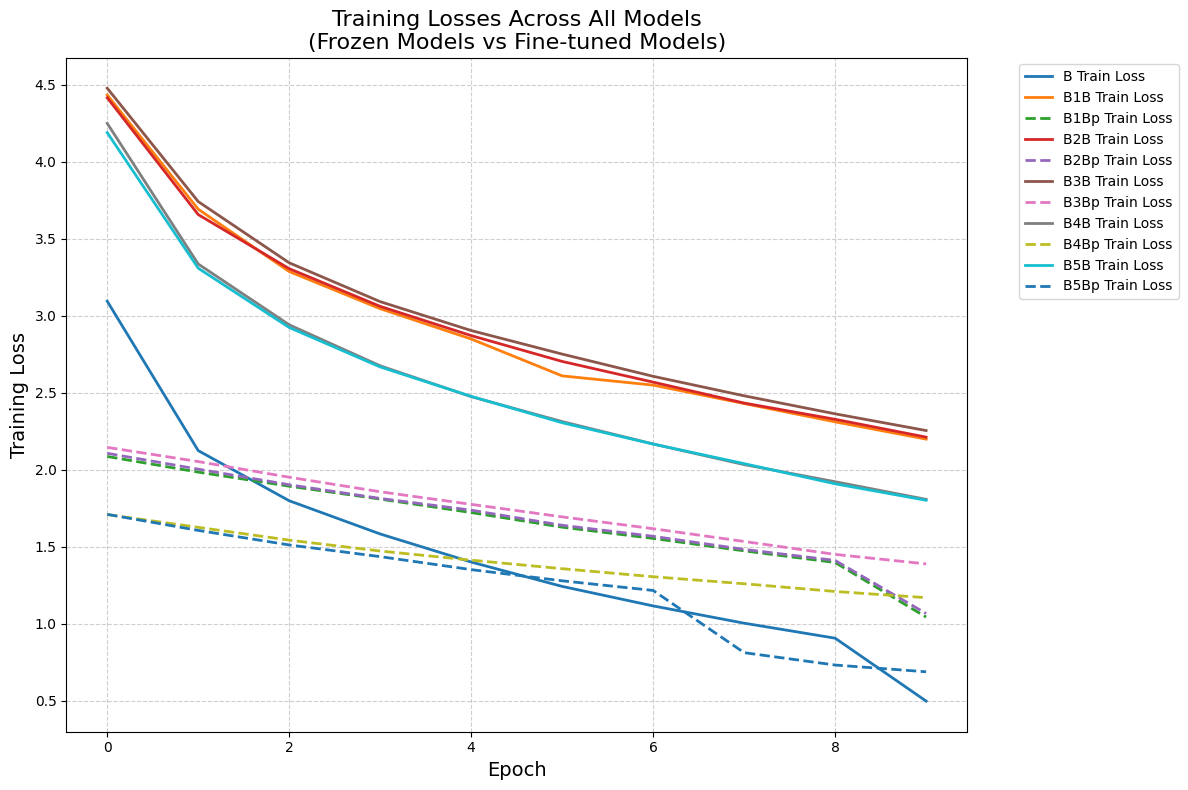

In [75]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))  # Bigger figure

# Loop through each model
for model_name, df in all_B_models_results.items():
    # Detect if model is fine-tuned or frozen
    if "p" in model_name.lower():  # fine-tuned models
        linestyle = "--"
    else:
        linestyle = "-"
        
    # Choose the correct column (first column is train_loss after our reset)
    plt.plot(df.iloc[:, 0], label=f"{model_name} Train Loss", linewidth=2, linestyle=linestyle)

plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Training Loss", fontsize=14)
plt.title("Training Losses Across All Models\n(Frozen Models vs Fine-tuned Models)", fontsize=16)

plt.grid(True, linestyle='--', alpha=0.6)

# Put the legend outside
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

plt.tight_layout()
plt.show()


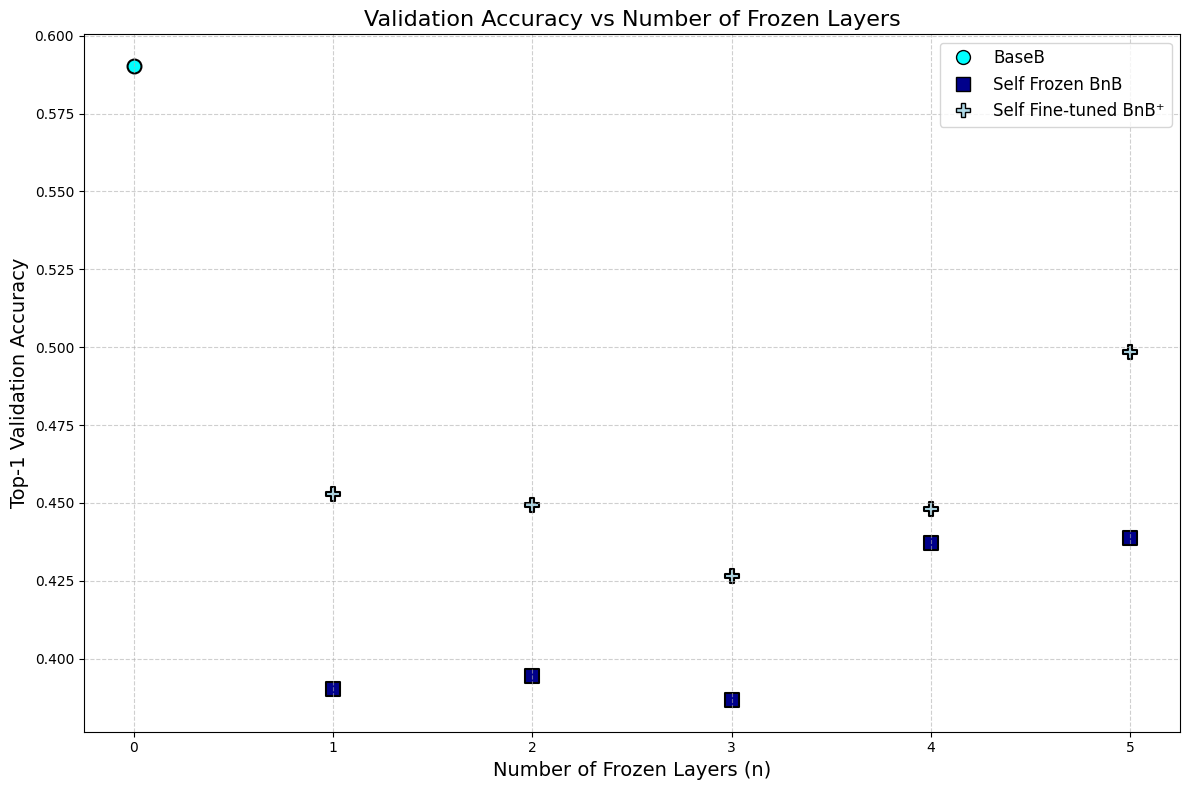

In [84]:
import matplotlib.pyplot as plt

# 1. Map models to x positions
x_positions = {
    "B": 0,
    "B1B": 1,
    "B1Bp": 1,
    "B2B": 2,
    "B2Bp": 2,
    "B3B": 3,
    "B3Bp": 3,
    "B4B": 4,
    "B4Bp": 4,
    "B5B": 5,
    "B5Bp": 5
}

# 2. Extract final val accuracies
x = []
y = []
colors = []
markers = []

for model_name, df in all_B_models_results.items():
    # Take last val_acc (fourth column, index -1)
    last_val_acc = df.iloc[-1, 3]
    
    x.append(x_positions[model_name])
    y.append(last_val_acc)
    if model_name == "B":
        colors.append("cyan")
        markers.append("o")
    elif model_name.endswith("p"):  # fine-tuned
        colors.append("lightblue")
        markers.append("P")  # plus inside marker
    else:  # frozen
        colors.append("darkblue")
        markers.append("s")  # circle

# 3. Plot
plt.figure(figsize=(12, 8))

# Plot each point separately
for i in range(len(x)):
    plt.scatter(x[i], y[i], color=colors[i], marker=markers[i], s=100, edgecolors='black', linewidth=1.5)

plt.xlabel("Number of Frozen Layers (n)", fontsize=14)
plt.ylabel("Top-1 Validation Accuracy", fontsize=14)
plt.title("Validation Accuracy vs Number of Frozen Layers", fontsize=16)
plt.grid(True, linestyle="--", alpha=0.6)

# Custom legend
from matplotlib.lines import Line2D

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='BaseB', markerfacecolor='cyan', markersize=10, markeredgecolor='black'),
    Line2D([0], [0], marker='s', color='w', label='Self Frozen BnB', markerfacecolor='darkblue', markersize=10, markeredgecolor='black'),
    Line2D([0], [0], marker='P', color='w', label='Self Fine-tuned BnB⁺', markerfacecolor='lightblue', markersize=10, markeredgecolor='black')
]
plt.legend(handles=legend_elements, loc='upper right', fontsize=12)

plt.xticks(range(6))
plt.tight_layout()
plt.show()


## AnB Plots

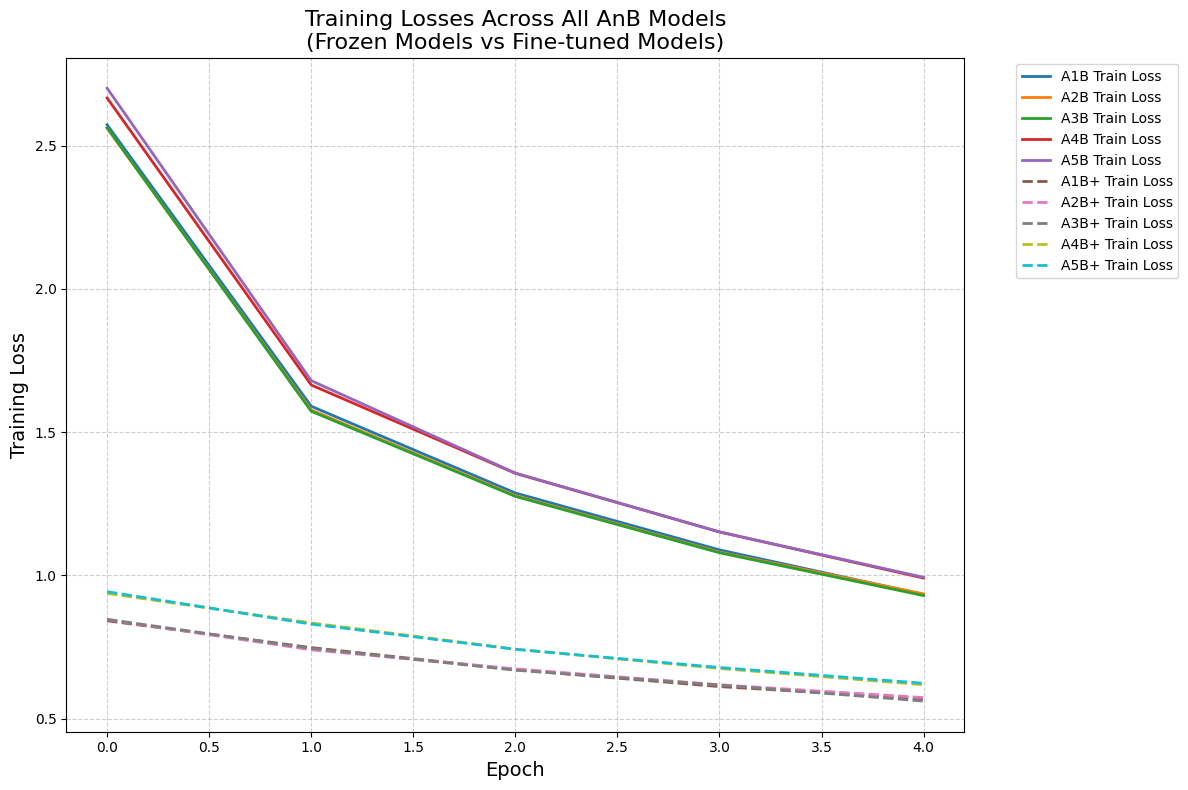

In [98]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

# Plot frozen models (solid lines)
for model_name, results in anb_results.items():
    plt.plot(
        results["train_losses"],
        label=f"{model_name} Train Loss",
        linewidth=2
    )

# Plot fine-tuned models (dashed lines)
for model_name, results in anb_plus_results.items():
    plt.plot(
        results["train_losses"],
        label=f"{model_name} Train Loss",
        linestyle='--',  # Dashed for fine-tuned
        linewidth=2
    )

plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Training Loss", fontsize=14)
plt.title("Training Losses Across All AnB Models\n(Frozen Models vs Fine-tuned Models)", fontsize=16)

plt.grid(True, linestyle="--", alpha=0.6)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.tight_layout()
plt.show()


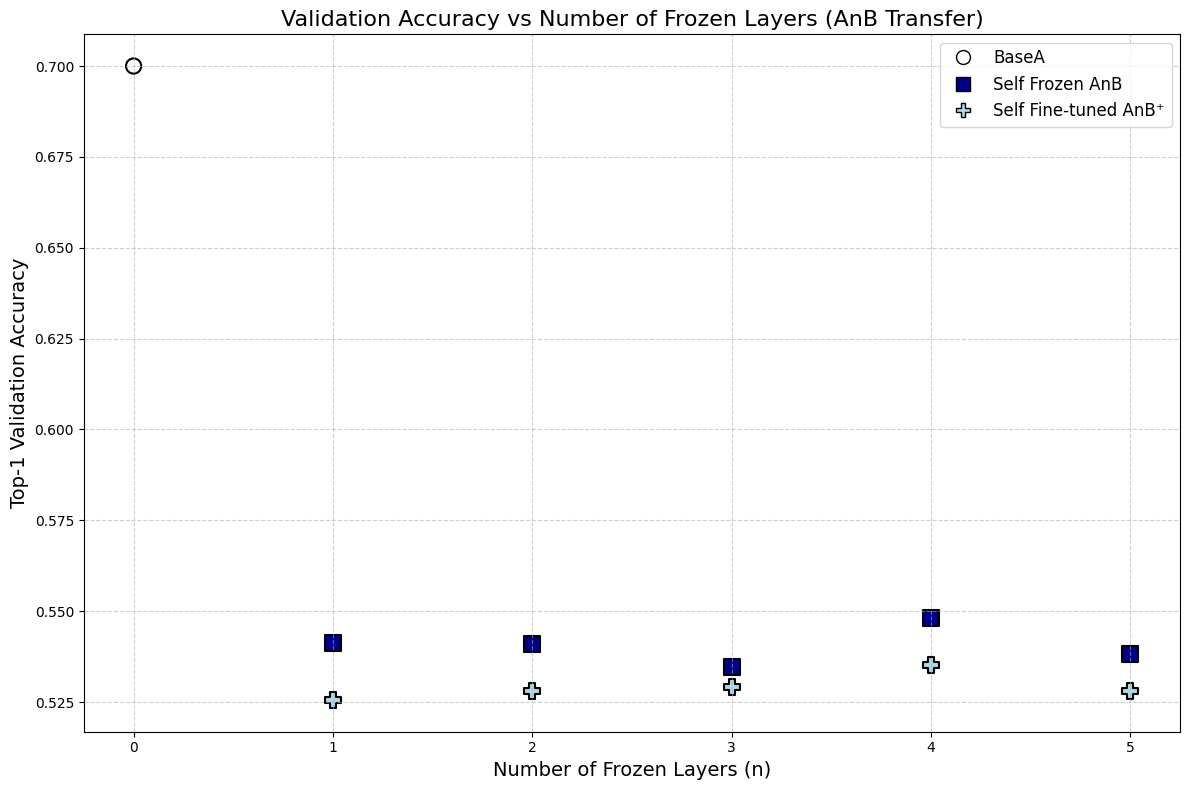

In [97]:
import matplotlib.pyplot as plt

# Let's assume you know this
baseA_val_acc = 0.70  # 👈 Change this to your actual BaseA final val accuracy

# 1. Prepare x, y, colors, markers
x = [0]  # BaseA x-position at 0
y = [baseA_val_acc]
colors = ["none"]  # Hollow
markers = ["o"]  # Circle

# 2. Loop over frozen models (A1B, A2B, ...)
for i in range(1, 6):
    model_name = f"A{i}B"
    last_val_acc = anb_results[model_name]["val_accuracies"][-1]  # Last epoch val acc
    x.append(i)
    y.append(last_val_acc)
    colors.append("darkblue")
    markers.append("s")  # Square

# 3. Loop over fine-tuned models (A1B+, A2B+, ...)
for i in range(1, 6):
    model_name = f"A{i}B+"
    last_val_acc = anb_plus_results[model_name]["val_accuracies"][-1]
    x.append(i)
    y.append(last_val_acc)
    colors.append("lightblue")
    markers.append("P")  # Plus

# 4. Plot
plt.figure(figsize=(12, 8))

for i in range(len(x)):
    plt.scatter(
        x[i], y[i],
        facecolors=colors[i],  # hollow for BaseA
        edgecolors='black',
        marker=markers[i],
        s=120,
        linewidth=1.5
    )

plt.xlabel("Number of Frozen Layers (n)", fontsize=14)
plt.ylabel("Top-1 Validation Accuracy", fontsize=14)
plt.title("Validation Accuracy vs Number of Frozen Layers (AnB Transfer)", fontsize=16)
plt.grid(True, linestyle="--", alpha=0.6)

# 5. Legend
from matplotlib.lines import Line2D

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='BaseA', markerfacecolor='none', markeredgecolor='black', markersize=10),
    Line2D([0], [0], marker='s', color='w', label='Self Frozen AnB', markerfacecolor='darkblue', markeredgecolor='black', markersize=10),
    Line2D([0], [0], marker='P', color='w', label='Self Fine-tuned AnB⁺', markerfacecolor='lightblue', markeredgecolor='black', markersize=10)
]
plt.legend(handles=legend_elements, loc='upper right', fontsize=12)

plt.xticks([0, 1, 2, 3, 4, 5])
plt.tight_layout()
plt.show()


# Combined Plot